# 1D Heat Equation

In [31]:
import m228
import emme as em
import anon
import jax
# anon.conf.config.update('jax_disable_jit', True)
import anon.atom as anp
import numpy as np
from anon import quad,step
import matplotlib.pyplot as plt
plt.style.use("typewriter")
CN = True
SAVE_FIGS = True
from elle_0001 import elem_0001

## Analytic Solution

In [32]:
alpha = 1/100
f = lambda x: anp.pi**2/100*sum(anp.sin((2*k+1)*anp.pi*x) for k in range(5))

pi = anp.pi
sin = anp.sin
cos = anp.cos
exp = anp.exp
def cn(t):
    return [
        pi**2*(pi*alpha*sin(pi*t)/(pi**3*alpha**2 + pi) 
            - cos(pi*t)/(pi**3*alpha**2 + pi))/100 
            + pi**2/(100*(pi**3*alpha**2*exp(pi**2*alpha*t) + pi*exp(pi**2*alpha*t))), 
        pi**2*(9*pi*alpha*sin(pi*t)/(81*pi**3*alpha**2 + pi) 
            - cos(pi*t)/(81*pi**3*alpha**2 + pi))/100
            + pi**2/(100*(81*pi**3*alpha**2*exp(9*pi**2*alpha*t) + pi*exp(9*pi**2*alpha*t))), 
        pi**2*(25*pi*alpha*sin(pi*t)/(625*pi**3*alpha**2 + pi) 
            - cos(pi*t)/(625*pi**3*alpha**2 + pi))/100 
            + pi**2/(100*(625*pi**3*alpha**2*exp(25*pi**2*alpha*t) + pi*exp(25*pi**2*alpha*t))), 
        pi**2*(49*pi*alpha*sin(pi*t)/(2401*pi**3*alpha**2 + pi) 
            - cos(pi*t)/(2401*pi**3*alpha**2 + pi))/100 
            + pi**2/(100*(2401*pi**3*alpha**2*exp(49*pi**2*alpha*t) + pi*exp(49*pi**2*alpha*t))), 
        pi**2*(81*pi*alpha*sin(pi*t)/(6561*pi**3*alpha**2 + pi) 
            - cos(pi*t)/(6561*pi**3*alpha**2 + pi))/100 
            + pi**2/(100*(6561*pi**3*alpha**2*exp(81*pi**2*alpha*t) + pi*exp(81*pi**2*alpha*t)))
     ]

def u(x,t):
    c = cn(t)
    return sum( 
        c[n] * anp.sin(xi*x)
            for n,xi in enumerate([(2*k+1)*anp.pi for k in range(5)])
    ) 


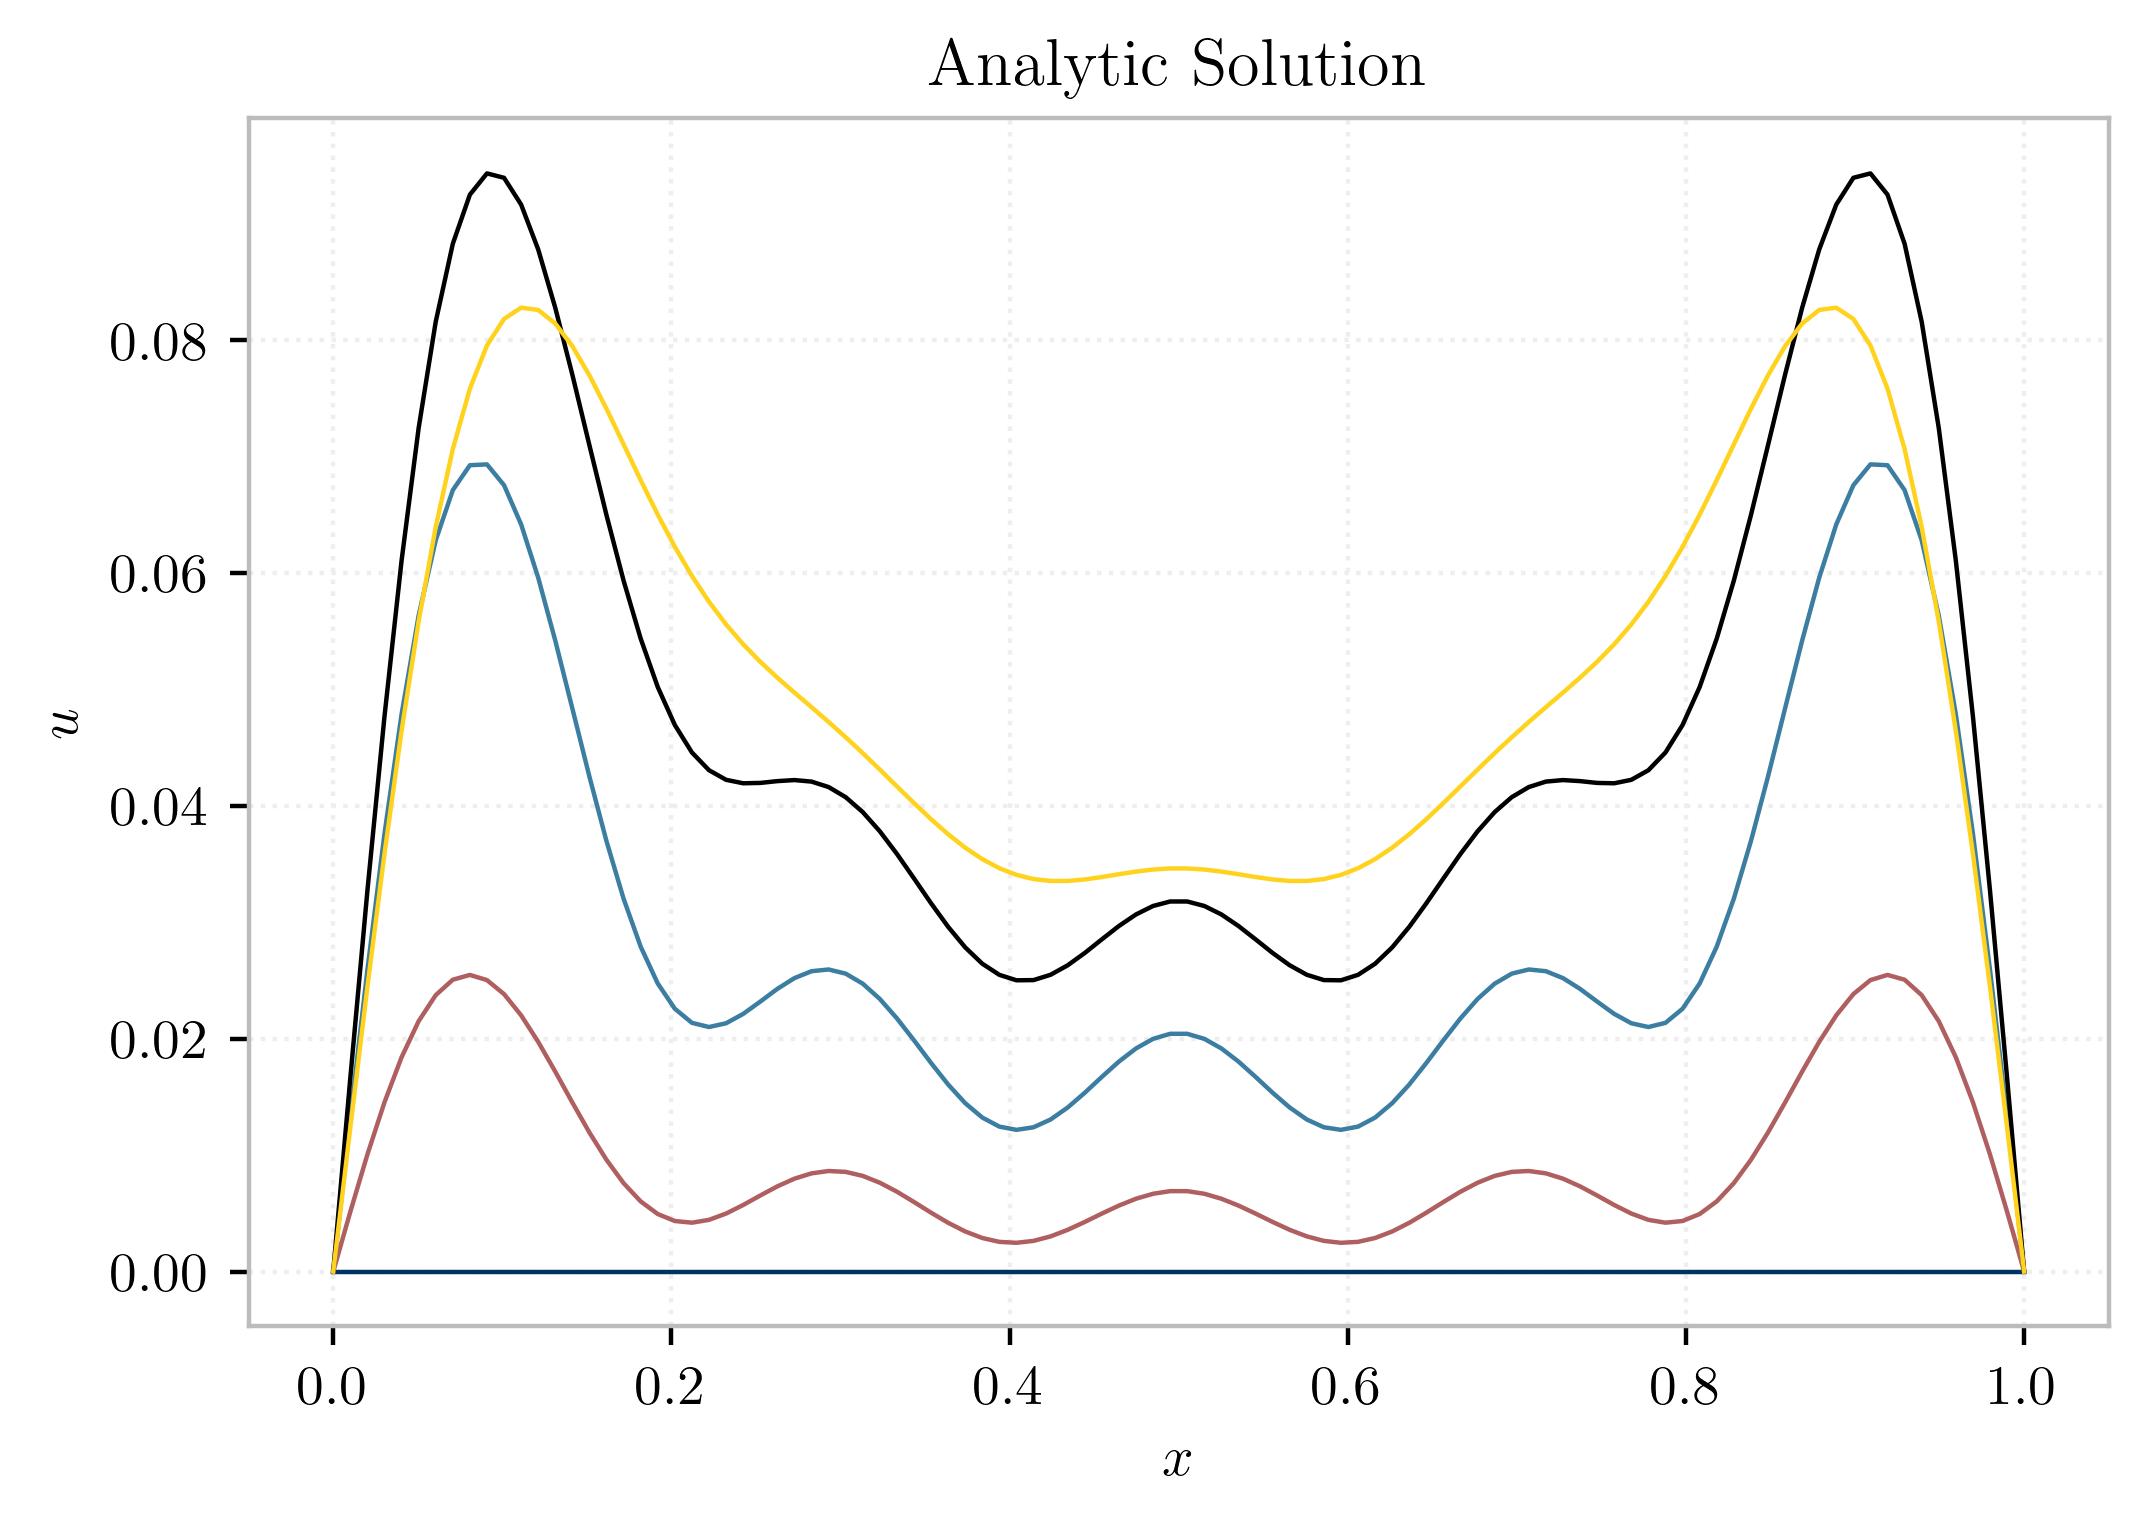

In [33]:
fig, ax = plt.subplots()
nx,nt = 100,5
dt = 1/(nt-1)

x = anp.linspace(0,1,nx)
for n in range(nt):
    ax.plot(x, u(x,n*dt))
ax.set_title("Analytic Solution")
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
if SAVE_FIGS: fig.savefig("./img/p3b-exact.png")

## SDIRK/FEM Solution

In [34]:
tableau = dict(
    A = (
        [  1./4.],
        [  1./2.,       1./4.],
        [ 17./50.,     -1./25.,    1./4. ],
        [371./1369., -137./2720., 15./544.,   1./4.],
        [ 25./24.,    -49./48.,   125./16., -85./12., 1./4.]
    ),
    b = [ 25./24.,    -49./48.,   125./16., -85./12., 1./4.],
    c = [  1/4   ,      3./4. ,    11./20.,   1./2. ,  1.0 ]

) if not CN else  dict(
    A = ([  0.0 ],
         [  1./2.,  1./2.]),
    b =  [  1./2.,  1./2.],
    c =  [  0.0,    1.0  ]
)

In [35]:
model = em.SkeletalModel(1,1)
a1 = model.param("a1")
a2 = model.param("a2")
elem = elem_0001(f, a1, a2, order=9)

In [36]:
def build(nel):
    model.clean(keep=["params"])
    L = 1.0
    nen = 5
    tag = 1
    model.node('1.1',0)
    for i in range(nel):
        nodes = [model.nodes[-1]]
        for j in range(1,nen):
            nodes.append(model.node(f"{i+1}.{j+1}", i*L/nel + (j)*(L/nel)/(nen-1)))
        model.elem(elem,nodes,f"{i}")
    model.boun("1.1", [1])
    model.boun(f"{nel}.{nen}", [1])
    
    b_ = model.compose_force()
    b__ = b_(0,0)
    jacb = b_.jacx
    M = jacb(0.,1.)
    Mi = anp.linalg.inv(M)
    A = -1/100.*Mi@jacb(1.,0.)
    return Mi@b__, Mi, A

def solve(dt,*model_vars):
    f__, Mi, A = model_vars
    U = anp.zeros((model.nf,3))
    stepper = jax.jit(step.rk_lin(dt,tableau,A,lambda t: f__*anp.sin(t*anp.pi),tridiag=False)["step"])
    X = [n.x for n in model.nodes[1:-1]]
    t = 0.0
    nt = int(1/dt)+1
    U = np.zeros((model.nf*nt,3))
    u = anp.zeros((model.nf,1))
    nf = model.nf
    for i in range(nt):
        u = stepper(u,t)
        U[i*nf: nf*(i+1), 2] = u.flatten()
        U[i*nf: nf*(i+1), 1] = t
        U[i*nf: nf*(i+1), 0] = X
        t = t + dt
    return U

def solve_last(dt,*model_vars):
    f__, Mi, A = model_vars
    U = anp.zeros((model.nf,3))
    stepper = jax.jit(step.rk_lin(dt,tableau,A,lambda t: f__*anp.sin(t*anp.pi),tridiag=False)["step"])
    X = [n.x for n in model.nodes[1:-1]]
    t = 0.0
    nt = int(1/dt)+1
    u = anp.zeros((model.nf,1))
    nf = model.nf
    for i in range(nt):
        u = stepper(u,t)
        t += dt
    return u

def build_and_run(dt,nel):
    model = build(nel)
    return solve(dt,model)

In [38]:
model_vars = build(20)

In [ ]:
U = solve(0.01,*model_vars)

In [ ]:
m228.plot.plot3d(*U.T)

In [ ]:
if not CN:
    fig, ax = m228.plot.plot2d(*U.T, slices=[0,0.2,0.4, 0.8, 1.0])
    ax.set_title("Transient FEM Solution")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x,t)$")
    if SAVE_FIG: fig.savefig("./img/p3b-fem.png")

5
10
20


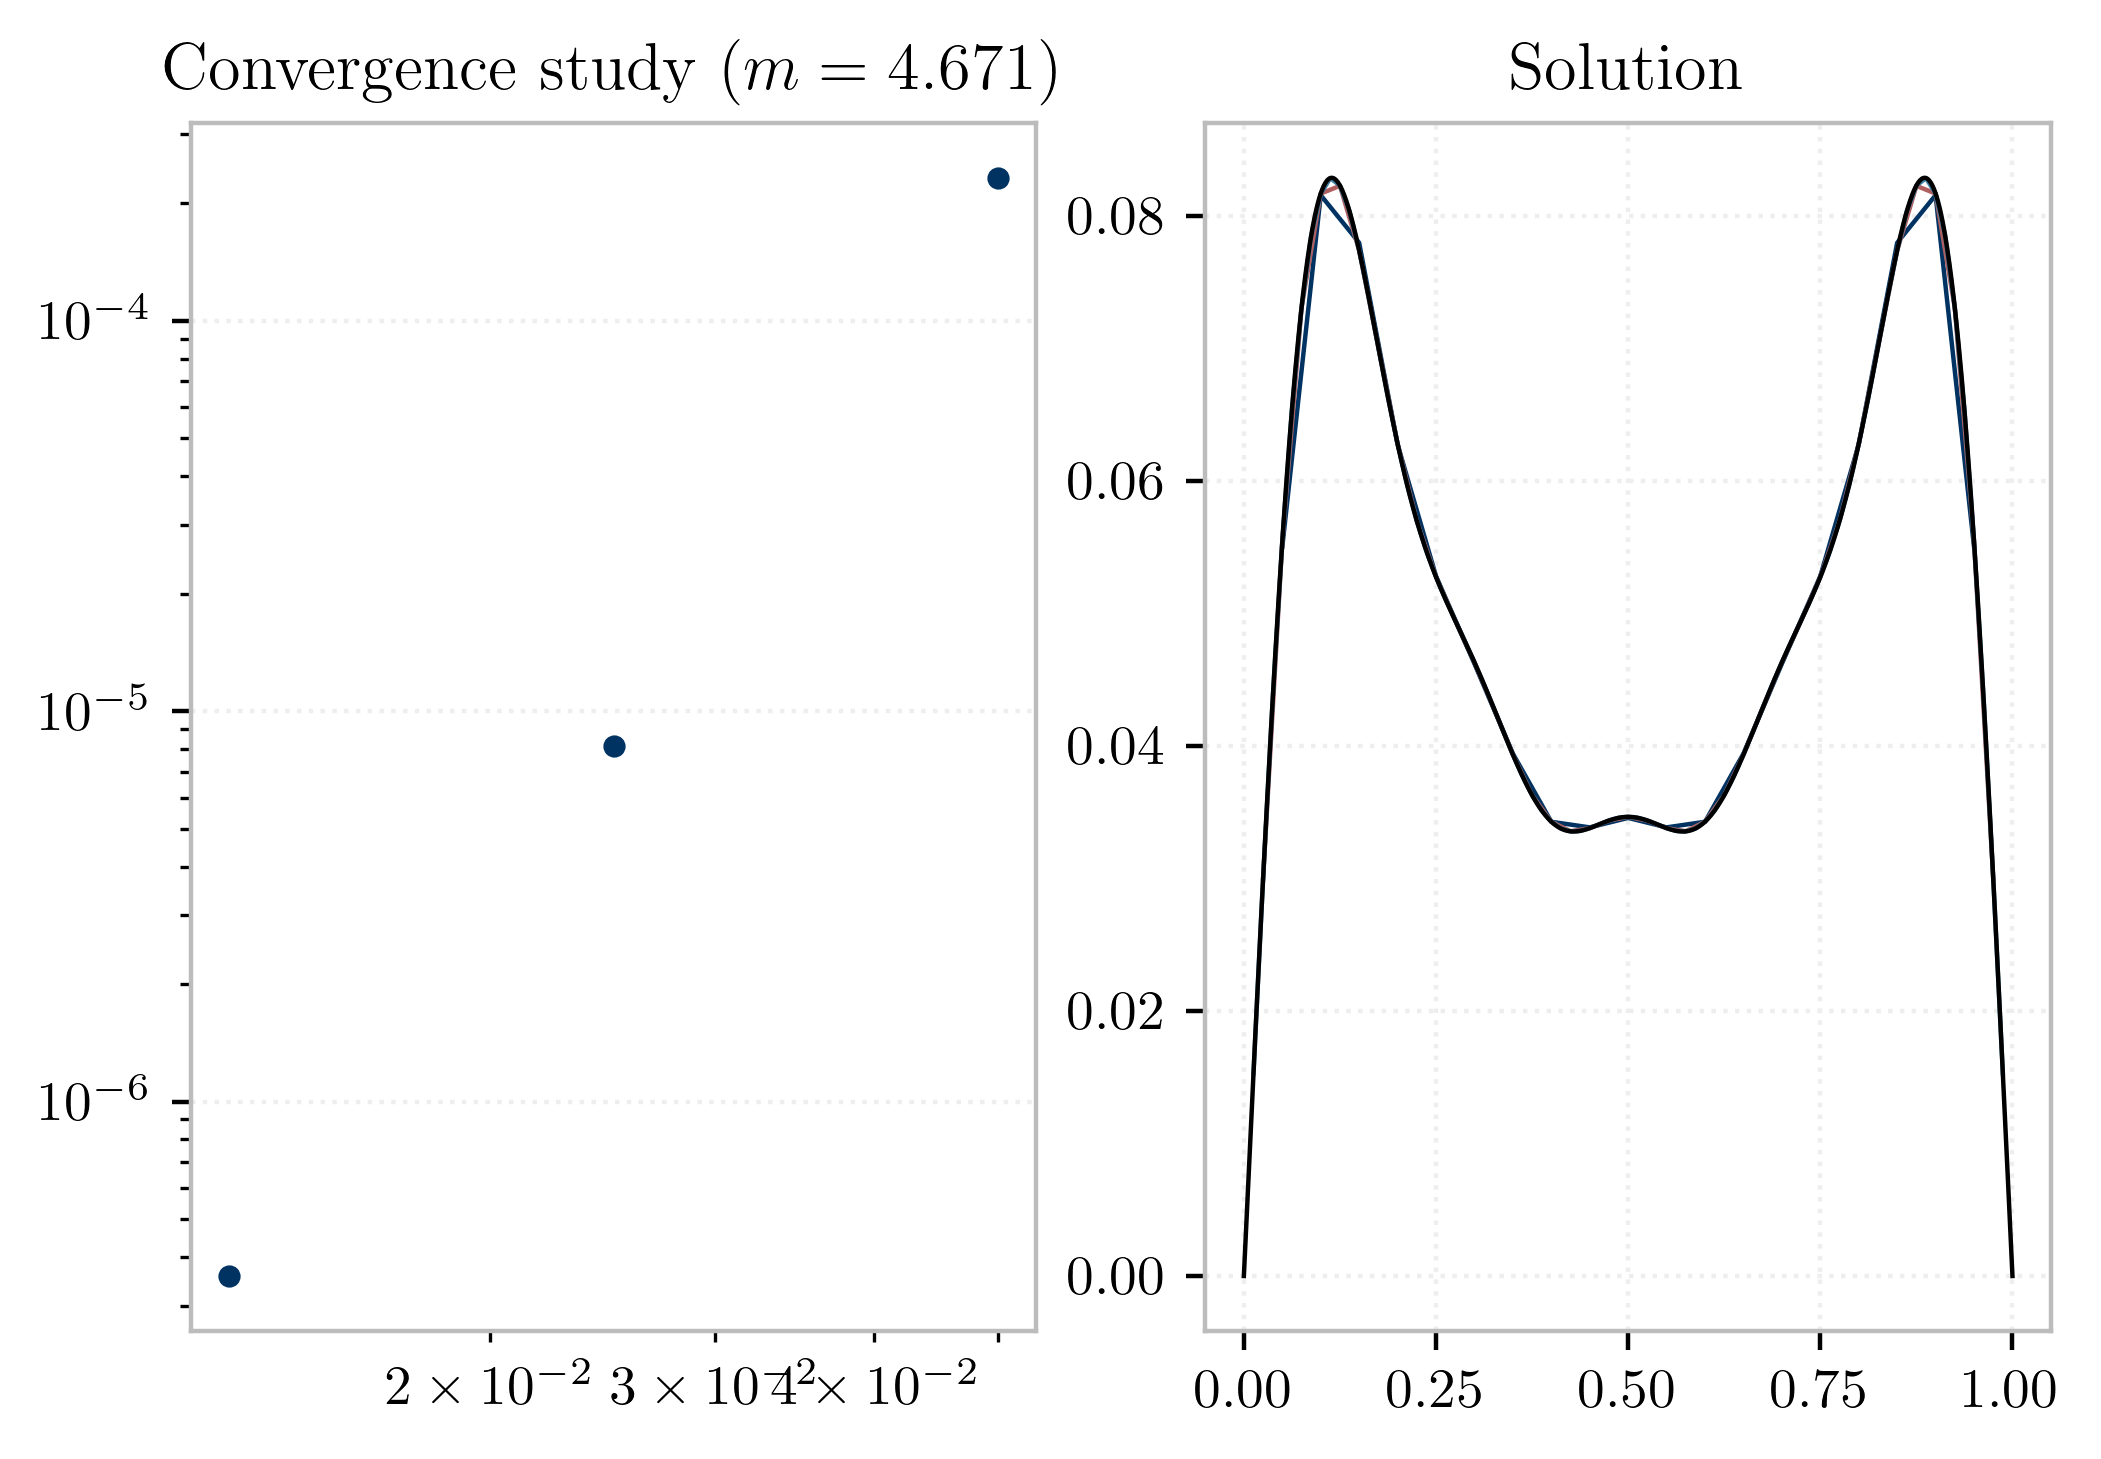

In [39]:
e = []
h = []
fig, ax = plt.subplots(1,2)
nu = 1/5
for n in [5,10,20]:
    print(n)
    model_vars = build(n)
    dt = nu*(1/(n*4))
    U = solve_last(dt,*model_vars)
    x = anp.linspace(model.nodes[1].x,model.nodes[-2].x,n*4-1)
    h.append(model.nodes[1].x)
    e.append(np.sqrt(model.nodes[1].x)*np.linalg.norm(U - u(x,1.0)[:,None]))
    ax[1].plot([n.x for n in model.nodes[1:model.nf+1] ], U.flatten())
    

slope,_ = np.polyfit(np.log(h), np.log(e), 1)

ax[1].plot(*zip(*[[x, u(x,1.0)] for x in anp.linspace(0,1,1000)]))
ax[1].set_title("Solution")

ax[0].loglog(h,e,".")
ax[0].set_title(f"Convergence study ($m={slope:.3f}$)")
if SAVE_FIGS: fig.savefig(f"./img/p3b-conv{'-cn' if CN else''}.png")